# QOSF Task 2

<font size="3.5"> 
This notebook has been written for the Quantum Open-Source Foundation Mentorship Program screening process.

The task is to implement a quantum circuit that returns |01> and |10> with equal probability. 

Requirements:
- The circuit should consist only of CNOTs, RXs and RYs.
- Start from all parameters in parametric gates being equal to 0 or randomly chosen.
- Find the right set of parameters using gradient descent (or more advanced optimization methods).
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise.

Compare the results for different numbers of measurements: 1, 10, 100, 1000.

Bonus question: How to make sure you produce state  |01⟩  +  |10⟩  and not any other combination of |01> + e(i*phi)|10⟩ (for example |01⟩  -  |10⟩)? 

<hr style="border-width:thin"> </hr>

Notebook pre-requisite installations (pip install): 
- qiskit 
- pylatexenc (for circuit display in mpl)
- pennylane-qiskit
</font>

Import all necessary libraries 
- numpy for various mathematical functions
- matplotlib for plotting visualizations
- qiskit for implementing quantum circuit and simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, IBMQ, Aer, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_vector, plot_state_qsphere, plot_histogram
from qiskit.aqua.components import optimizers
from qiskit.providers.aer.noise import NoiseModel

Define backend simulators and import noise model:

In [2]:
# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_valencia')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

qasm_backend = Aer.get_backend('qasm_simulator')
statevector_backend = Aer.get_backend('statevector_simulator')

/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Initialise the desired |01> + |10> state explicitly and plot on Q-sphere for visualisation. $\frac{1}{\sqrt2}$ coefficients ensure that the state is normalised and has equal probability of measuring |01> and |10>.

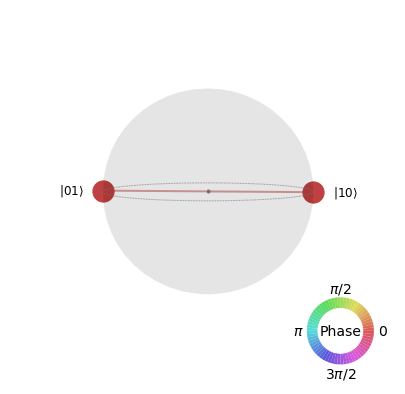

In [3]:
bell_coeffs = [0, 1/np.sqrt(2), 1/np.sqrt(2), 0]
bell_state = Statevector(bell_coeffs)
plot_state_qsphere(bell_state)

Set up two-qubit quantum circuit:

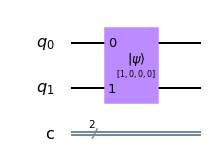

In [4]:
def initializeCircuit():
    '''
    Initialize a two-qubit circuit with |00> initial state.
    
    Returns
    -------
    circuit: QuantumCircuit
        Quantum circuit object that contains list of instructions bound to some registers
    
    q_reg: QuantumRegister
        Quantum register object to handle qubits in circuit
    
    c_reg: ClassicalRegister
        Classical register object to handle target bits in circuit
    
    '''
    
    #Qiskit initializes qubits to the |0> state by default, but here we initialise it explicitly
    initial_state = [1., 0., 0., 0.]
    
    #Define a two-qubit quantum register and two-bit classical register
    q_reg = QuantumRegister(2, 'q')
    c_reg = ClassicalRegister(2, 'c')
    
    #Define circuit with registers and initialize to the |00> state
    circuit = QuantumCircuit(q_reg, c_reg)
    circuit.initialize(initial_state, [q_reg[0], q_reg[1]])
    
    return circuit, q_reg, c_reg
    
initial_circ, q_reg, c_reg = initializeCircuit()
initial_circ.draw('mpl')

Build Bell state circuit using Hadamard and CNOT gates:

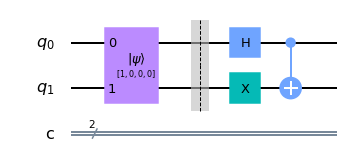

In [5]:
#Initialize |00> state
circ, q_reg, c_reg = initializeCircuit()

#Apply gates to transform to desired Bell state
circ.barrier()
circ.x(q_reg[1])
circ.h(q_reg[0])
circ.cx(q_reg[0],q_reg[1])

#Display circuit
circ.draw('mpl')

Plotting the final state on the Q-sphere before measurement to check that it is indeed the desired Bell state.

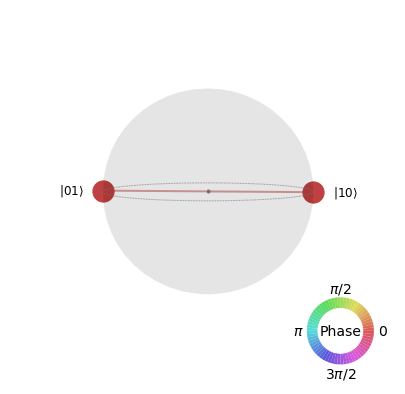

In [6]:
final_state = execute(circ, statevector_backend).result().get_statevector()
plot_state_qsphere(final_state)

Measurement of the final state over 1000 iterations and results plotted on a histogram.

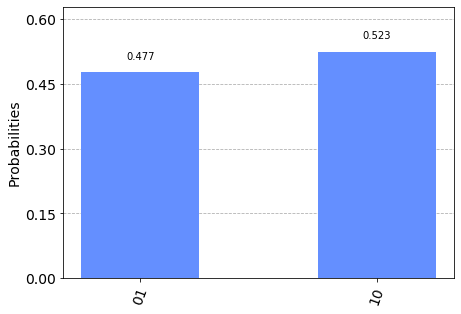

In [7]:
#Measure qubits
circ.barrier()
circ.measure(q_reg, c_reg)

#Run circuit on backend and output histogram
counts = execute(circ, qasm_backend, shots=1000).result().get_counts()
plot_histogram(counts)

Circuit implemented that successfully returns the desired state, using the Hadamard gate. Now, in order to satisfy the requirements, we need to decompose the Hadamard gate into RX, RY gates only. We know that this is possible because the single-qubit and CNOT gates are universal.

describe decomposition of H

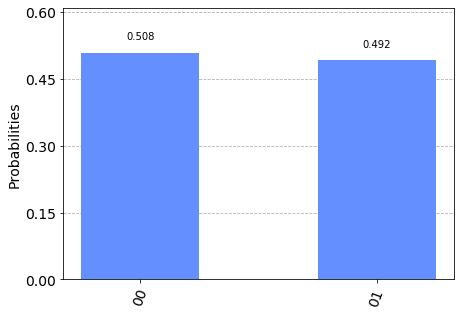

In [8]:
#H = XY^(1/2) (is this right? need to track global phase)
circ, q_reg, c_reg = initializeCircuit()
circ.ry(np.pi/2, q_reg[0])
circ.rx(np.pi, q_reg[0])
circ.measure(q_reg, c_reg)

counts = execute(circ, qasm_backend, shots=1000).result().get_counts()
plot_histogram(counts)

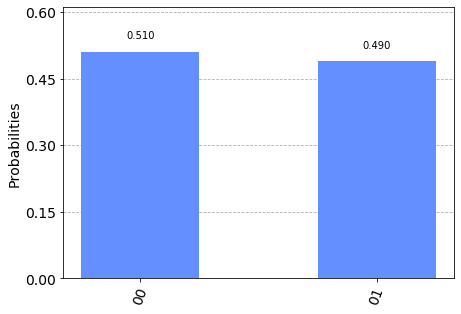

In [9]:
#H = Y^(-1/2)X
circ, q_reg, c_reg = initializeCircuit()
circ.rx(np.pi, q_reg[0])
circ.ry(-np.pi/2, q_reg[0])
circ.measure(q_reg, c_reg)

counts = execute(circ, qasm_backend, shots=1000).result().get_counts()
plot_histogram(counts)

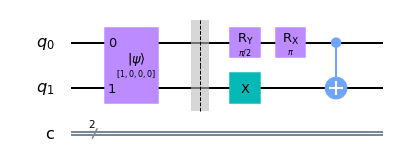

In [10]:
#Create Bell state using RX, RY and CNOT gates

#Initialize |00> state
circ, q_reg, c_reg = initializeCircuit()

#Apply gates to transform to desired Bell state
circ.barrier()
circ.x(q_reg[1])

#Decomposed H
circ.ry(np.pi/2, q_reg[0])
circ.rx(np.pi, q_reg[0])

circ.cx(q_reg[0],q_reg[1])

#Display circuit
circ.draw('mpl')

Plotting the final state on the Q-sphere before measurement to check that it is indeed the desired Bell state.

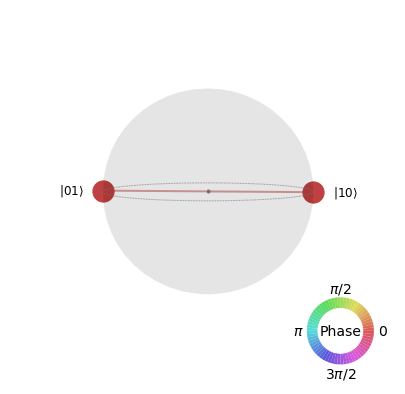

In [11]:
final_state = execute(circ, statevector_backend).result().get_statevector()
plot_state_qsphere(final_state)

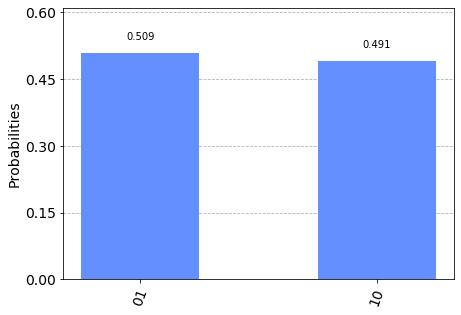

In [12]:
#Measure qubits
circ.barrier()
circ.measure(q_reg, c_reg)

#Run circuit on backend and output results
counts = execute(circ, qasm_backend, shots=1000).result().get_counts()
plot_histogram(counts)

Desired state successfully obtained using decomposed circuit.

Now we need to implement a parameter optimization method to parameterize the single-qubit gates. 

Bell state generator works with known gate parameters from theory.

# Parameter optimization using Gradient Descent (noiseless)

mean squared error cost function

In [13]:
import pennylane as qml

In [75]:
# Define backend using PennyLane default.qubit simulator
device = qml.device("qiskit.aer", wires=['q0', 'q1'], backend='qasm_simulator', shots=1000, analytic=False)

# Define parameterized quantum circuit using QNode decorator
@qml.qnode(device)
def circuit(params):
    qml.RY(params[0], wires='q0')
    qml.RX(params[1], wires='q0')
    qml.PauliX(wires='q1')
    qml.CNOT(wires=['q0','q1'])
    
    return qml.probs(wires=['q0','q1'])

# Define mean-squared error cost function 
def cost_func(params):
    return 0.25 * ((circuit(params)[0])**2 + 
                   (circuit(params)[1] - 0.5)**2 +
                   (circuit(params)[2] - 0.5)**2 +
                   (circuit(params)[3])**2)


In [76]:
# Initialize parameters using random values between 0 and 2pi
init_params = [np.random.uniform(0, 2*np.pi) for i in range(2)]

# Set the initial parameter values
theta = init_params.copy()

# Define gradient descent optimizer and set number of optimization steps
opt = qml.GradientDescentOptimizer(stepsize=0.5)

# Set the number of optimization steps
steps = 100

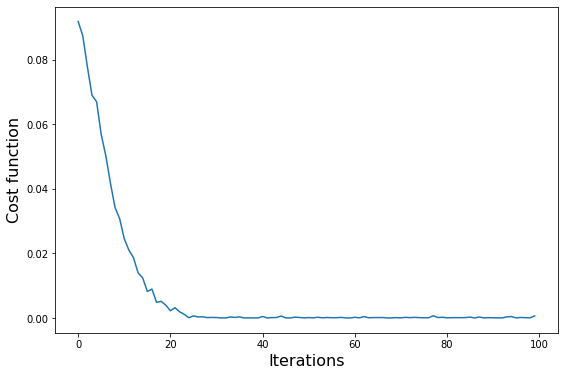

In [77]:
# Evaluate cost function at each step and terminate when termination condition is reached
cost = []
for i in range(steps):
    theta = opt.step(cost_func, theta)
    cost.append(cost_func(theta))
        
    if len(cost) >= 2:
        abstol = cost_func(theta)
        if abstol <= 1e-7:
            print("Termination condition reached after {} steps.".format(len(cost)))
            break
            
plt.figure(figsize=(9,6))
plt.plot(cost)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Cost function', fontsize=16)
plt.show()

In [78]:
print("Optimized angle for RY gate = {}".format(round(theta[0], 3)))
print("Optimized angle for RX gate = {}".format(round(theta[1], 3)))

Optimized angle for RY gate = 4.716
Optimized angle for RX gate = 3.345


In [94]:
probs = circuit(theta)
probs

array([0.   , 0.506, 0.494, 0.   ])

Plot histogram of probabilities of measuring different two-qubit states:

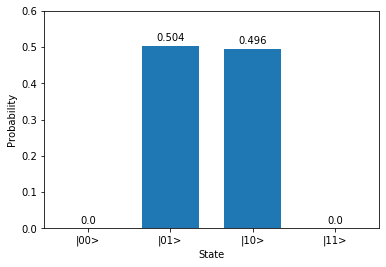

In [84]:
bins = ['|00>', '|01>', '|10>', '|11>']
probs = [i for i in circuit(theta)]

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, ax = plt.subplots()
rects = plt.bar(bins, probs, width=0.7)
autolabel(rects)
ax.set_ylabel('Probability')
ax.set_xlabel('State')
plt.ylim(0, 0.6)
plt.show()

# Parameter optimization using Gradient Descent (noisy)

In [20]:
# Define backend using PennyLane qiskit.aer noisy simulator
device = qml.device("qiskit.aer", wires=['q0', 'q1'], shots=1000,
                    basis_gates=basis_gates,
                    coupling_map=coupling_map,
                    noise_model=noise_model, 
                    analytic=False)

In [21]:
# Initialize parameters using same random values as noiseless
theta = init_params.copy()

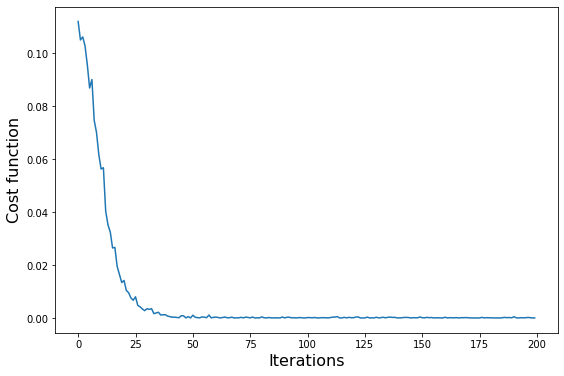

In [22]:
# Evaluate cost function at each step and terminate when termination condition is reached
cost = []
for i in range(steps):
    theta = opt.step(cost_func, theta)
    cost.append(cost_func(theta))
        
    if len(cost) >= 2:
        abstol = cost_func(theta)
        if abstol <= 1e-7:
            print("Termination condition reached after {} steps.".format(len(cost)))
            break
            
plt.figure(figsize=(9,6))
plt.plot(cost)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Cost function', fontsize=16)
plt.show()

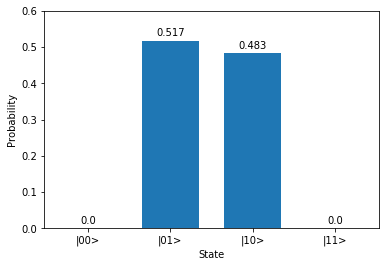

In [23]:
bins = ['|00>', '|01>', '|10>', '|11>']
probs = [round(i, 4) for i in circuit(theta)]

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, ax = plt.subplots()
rects = plt.bar(bins, probs, width=0.7)
autolabel(rects)
ax.set_ylabel('Probability')
ax.set_xlabel('State')
plt.ylim(0, 0.6)
plt.show()